# Assignment for brain

## 1. Data Exploration

### Package imports.

- nibabel: visualization

In [1]:
import os
import glob
import re
import pandas as pd
# For excel reading, also install openpyxl
import numpy as np
import torch
# from sklearn.model_selection import train_test_split
import nibabel as nib
import matplotlib.pyplot as plt


### Constants

- `BASE_PATH`: The location of the image files

In [14]:
BASE_PATH = 'Data/'
TCIA_LOCATION = BASE_PATH + 'TCIA/'
TCIA_EXCEL = TCIA_LOCATION + 'HCC-TACE-Seg_clinical_data-V2.xlsx'
TCIA_RESULTS_PATH = TCIA_LOCATION + 'TCIA_results_phase_PV/'
TCIA_IMG_PATH = TCIA_LOCATION + 'TCIA_image_PV/'
TCIA_IMG_SUFFIX = '_PV.nii.gz'

### Data exploration 

In [3]:
data = pd.read_excel(TCIA_EXCEL)

In [4]:
data.head()

,TCIA_ID,Interval_BL,Interval_FU,TTP,Death_1_StillAliveorLostToFU_0,Censored_0_progressed_1,OS,hepatitis,age,agegp,...,3_RECIST,1_mRECIST_BL,1_mRECIST_FU,1_mRECIST,2_mRECIST_BL,2_mRECIST_FU,2_mRECIST,3_mRECIST_BL,3_mRECIST_FU,3_mRECIST
0,HCC_001,-18,20.43,197.000000,1,1,350.285714,HCV only,71,>70,...,3.0,44.5,0.0,1.0,43.0,0.0,1.0,43.0,0.0,1.0
1,HCC_002,84,22.86,20.714286,1,0,25.285714,HBV only,72,>70,...,3.0,103.7,58.6,2.0,107.0,69.0,2.0,106.0,58.6,2.0
2,HCC_003,3,7.00,5.571429,1,1,21.428571,HCV only,53,51-60,...,3.0,162.2,173.9,3.0,87.0,127.0,4.0,127.0,138.0,3.0
3,HCC_004,1,7.57,5.428571,1,0,10.285714,No virus,80,>70,...,3.0,70.8,70.8,3.0,65.0,44.0,2.0,65.0,50.9,3.0
4,HCC_005,435,13.86,12.857143,1,0,56.285714,No virus,73,>70,...,3.0,70.2,62.1,3.0,67.0,62.0,3.0,63.3,68.2,3.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 57 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   TCIA_ID                         105 non-null    object 
 1   Interval_BL                     105 non-null    int64  
 2   Interval_FU                     97 non-null     float64
 3   TTP                             105 non-null    float64
 4   Death_1_StillAliveorLostToFU_0  105 non-null    int64  
 5   Censored_0_progressed_1         105 non-null    int64  
 6   OS                              105 non-null    float64
 7   hepatitis                       105 non-null    object 
 8   age                             105 non-null    int64  
 9   agegp                           105 non-null    object 
 10  Sex                             105 non-null    int64  
 11  Smoking                         105 non-null    int64  
 12  Alcohol                         105 

In [6]:
data['TCIA_ID'][:5]

0    HCC_001
1    HCC_002
2    HCC_003
3    HCC_004
4    HCC_005
Name: TCIA_ID, dtype: object

In [7]:
data['TCIA_ID'].count()

105

In [8]:
'Unique ids: %d' % data['TCIA_ID'].value_counts().shape[0]

'Unique ids: 105'

Some files are not present. Let's remove them from the dataset

In [15]:
def img_join(id):
    return os.path.join(TCIA_IMG_PATH, id + TCIA_IMG_SUFFIX)

def results_join(id):
    return os.path.join(TCIA_RESULTS_PATH, id + TCIA_IMG_SUFFIX)

data['img_path'] = data['TCIA_ID'].apply(img_join)
data['result_path'] = data['TCIA_ID'].apply(results_join)

data[['TCIA_ID', 'img_path', 'result_path']].head()

,TCIA_ID,img_path,result_path
0,HCC_001,Data/TCIA/TCIA_image_PV/HCC_001_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_001_PV.nii.gz
1,HCC_002,Data/TCIA/TCIA_image_PV/HCC_002_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_002_PV.nii.gz
2,HCC_003,Data/TCIA/TCIA_image_PV/HCC_003_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_003_PV.nii.gz
3,HCC_004,Data/TCIA/TCIA_image_PV/HCC_004_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_004_PV.nii.gz
4,HCC_005,Data/TCIA/TCIA_image_PV/HCC_005_PV.nii.gz,Data/TCIA/TCIA_results_phase_PV/HCC_005_PV.nii.gz


In [18]:
def file_exists(file_path):
    exists = os.path.exists(file_path)
    if not exists:
        print('WARN: File not found: %s' % file_path)
    return exists

original = len(data)
data = data[data['result_path'].apply(file_exists)]

print('%d files not found' % (original - len(data)))

0 files not found


### Data visualization

Display the first available image

**Original**

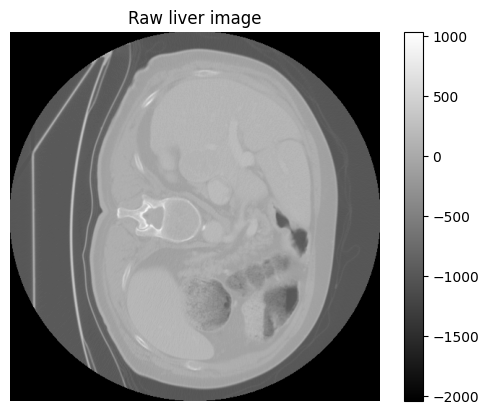

In [19]:
# Load the .nii.gz file
img = nib.load(data.iloc[0]['img_path'])

# Get the image data
img_data = img.get_fdata()

# Display a slice of the neuroimaging data
plt.imshow(img_data[:, :, img_data.shape[2] // 2], cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('Raw liver image')
plt.show()


**Mask**

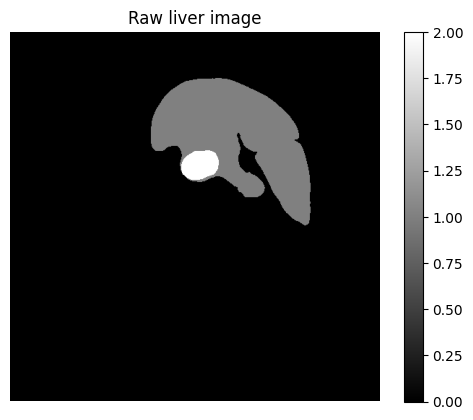

In [21]:
# Load the .nii.gz file
img = nib.load(data.iloc[0]['result_path'])

# Get the image data
img_data = img.get_fdata()

# Display a slice of the neuroimaging data
plt.imshow(img_data[:, :, img_data.shape[2] // 2], cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('Raw liver image')
plt.show()


### Display random images

In [28]:
# Extract 9 random images
random_images = np.random.choice(len(data), size=4, replace=False)

random_images

array([28, 83, 25, 99])

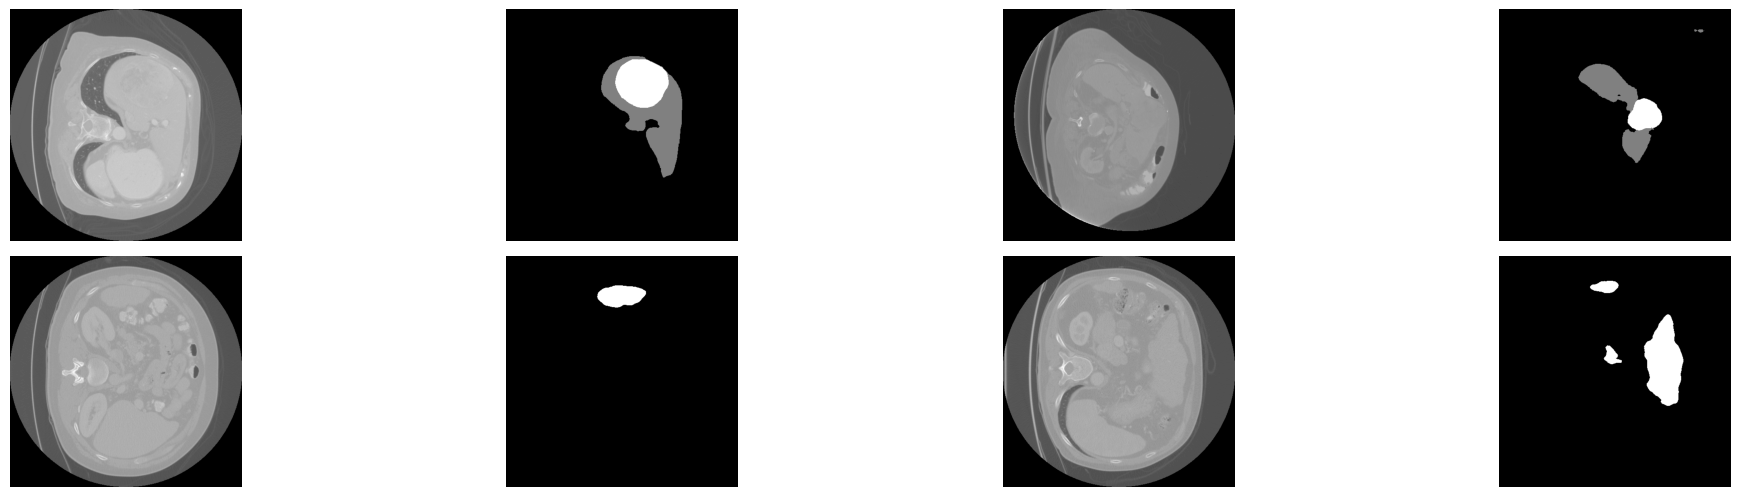

In [35]:
plt.figure(figsize=(20,10))

def display_img(img_path, pos):
    plt.subplot(4, 4, pos)
    img = nib.load(img_path)
    img_data = img.get_fdata()
    plt.imshow(img_data[:, :, img_data.shape[2] // 2], cmap='gray')
    plt.axis('off')

for i in range(len(random_images)):
    # Load the .nii.gz file
    display_img(data.iloc[random_images[i]]['img_path'], i + (i + 1))
    display_img(data.iloc[random_images[i]]['result_path'], i + (i + 2))

plt.tight_layout()

![Dog Meme](https://i.pinimg.com/474x/81/9d/5d/819d5df2b9b8798e21aa5fc1becec80a--number--dog-memes.jpg)
